In [1]:
#安装相应package
#!pip install numpy pandas matplotlib requests tqdm opencv-python 
# !pip install numpy pandas matplotlib seaborn plotly requests tqdm opencv-python pillow wandb -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
#测试torch
# import torch 
# torch.__version__

In [3]:
#中文字体文件
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf --no-check-certificate

--2023-04-01 16:08:18--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf
正在解析主机 zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
正在连接 zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)|121.36.235.132|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度： 10050868 (9.6M) [application/x-font-ttf]
正在保存至: “SimHei.ttf.3”

SimHei.ttf.3        100%[===================>]   9.58M  38.1MB/s    用时 0.3s    

2023-04-01 16:08:19 (38.1 MB/s) - 已保存 “SimHei.ttf.3” [10050868/10050868])



In [4]:
import os

In [5]:

# 存放结果文件
os.mkdir('output1')

# 存放训练得到的模型权重
os.mkdir('checkpoint1')


# 存放生成的图表
os.mkdir('图表1')

# 准备数据集

In [6]:
# !git clone https://github.com/JasonYangCode/AppleLeaf9

# 导入工具包

In [7]:
import time
import os

import numpy as np
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


# 图像预处理

In [8]:
from torchvision import transforms
target_size = (224,224)
# 训练集图像预处理：缩放裁剪、图像增强、转 Tensor、归一化
train_transform = transforms.Compose([transforms.Resize(target_size),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])


# 加载数据集

In [9]:
# 数据集文件夹路径
dataset_dir = 'AppleLeaf9_split'
#训练集路径
train_path = os.path.join(dataset_dir, 'train')
#测试集路径
test_path = os.path.join(dataset_dir, 'val')
print('训练集路径', train_path)
print('测试集路径', test_path)

训练集路径 AppleLeaf9_split/train
测试集路径 AppleLeaf9_split/val


In [10]:
from torchvision import datasets
#是否输入train_transform、test_transform参数可以选择是否对训练集和测试集进行数据增强，目前是未进行数据增强
# 载入训练集
train_dataset = datasets.ImageFolder(train_path, train_transform)

# 载入测试集
test_dataset = datasets.ImageFolder(test_path, test_transform)

print('训练集图像数量', len(train_dataset))
print('类别个数', len(train_dataset.classes))
print('各类别名称', train_dataset.classes)
print('测试集图像数量', len(test_dataset))
print('类别个数', len(test_dataset.classes))
print('各类别名称', test_dataset.classes)

训练集图像数量 11669
类别个数 9
各类别名称 ['Alternaria leaf spot', 'Brown spot', 'Frogeye leaf spot', 'Grey spot', 'Health', 'Mosaic', 'Powdery mildew', 'Rust', 'Scab']
测试集图像数量 2913
类别个数 9
各类别名称 ['Alternaria leaf spot', 'Brown spot', 'Frogeye leaf spot', 'Grey spot', 'Health', 'Mosaic', 'Powdery mildew', 'Rust', 'Scab']


In [11]:
print('测试集图像数量', len(test_dataset))
print('类别个数', len(test_dataset.classes))
print('各类别名称', test_dataset.classes)

测试集图像数量 2913
类别个数 9
各类别名称 ['Alternaria leaf spot', 'Brown spot', 'Frogeye leaf spot', 'Grey spot', 'Health', 'Mosaic', 'Powdery mildew', 'Rust', 'Scab']


In [12]:
# 各类别名称
class_names = train_dataset.classes
n_class = len(class_names)
# 映射关系：类别 到 索引号
train_dataset.class_to_idx
# 映射关系：索引号 到 类别
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}
# 保存为本地的 npy 文件
np.save('idx_to_labels.npy', idx_to_labels)
np.save('labels_to_idx.npy', train_dataset.class_to_idx)
class_names

['Alternaria leaf spot',
 'Brown spot',
 'Frogeye leaf spot',
 'Grey spot',
 'Health',
 'Mosaic',
 'Powdery mildew',
 'Rust',
 'Scab']

In [13]:
# 映射关系：类别 到 索引号
train_dataset.class_to_idx

{'Alternaria leaf spot': 0,
 'Brown spot': 1,
 'Frogeye leaf spot': 2,
 'Grey spot': 3,
 'Health': 4,
 'Mosaic': 5,
 'Powdery mildew': 6,
 'Rust': 7,
 'Scab': 8}

In [14]:
# 映射关系：索引号 到 类别
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}
idx_to_labels

{0: 'Alternaria leaf spot',
 1: 'Brown spot',
 2: 'Frogeye leaf spot',
 3: 'Grey spot',
 4: 'Health',
 5: 'Mosaic',
 6: 'Powdery mildew',
 7: 'Rust',
 8: 'Scab'}

# 定义数据加载器

In [15]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# 训练集的数据加载器
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4
                         )

# 测试集的数据加载器
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4
                        )

# 查看一个batch中的img和label


In [16]:
# DataLoader 是 python生成器，每次调用返回一个 batch 的数据
images, labels = next(iter(train_loader))

In [17]:
images.shape

torch.Size([32, 3, 224, 224])

In [18]:
labels

tensor([8, 8, 8, 8, 2, 8, 2, 8, 8, 2, 7, 7, 8, 2, 7, 7, 7, 2, 8, 2, 6, 2, 7, 2,
        2, 7, 8, 2, 2, 6, 8, 7])

# 可视化一个batch的图像和标注

In [19]:
# 将数据集中的Tensor张量转为numpy的array数据类型
images = images.numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'label:8')

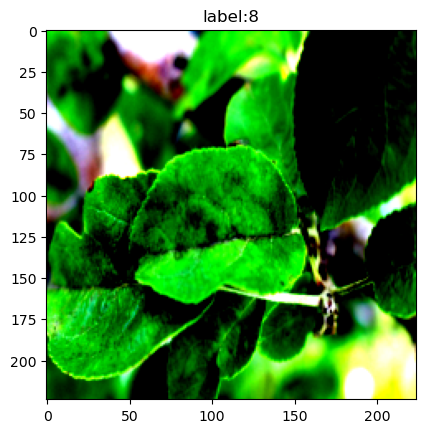

In [20]:
# batch 中经过预处理的图像
idx = 2
plt.imshow(images[idx].transpose((1,2,0))) # 转为(224, 224, 3)
plt.title('label:'+str(labels[idx].item()))

In [21]:
# 显示类别数字
label = labels[idx].item()
label

8

In [22]:
# 显示类别数字对应的类别
pred_classname = idx_to_labels[label]
pred_classname

'Scab'

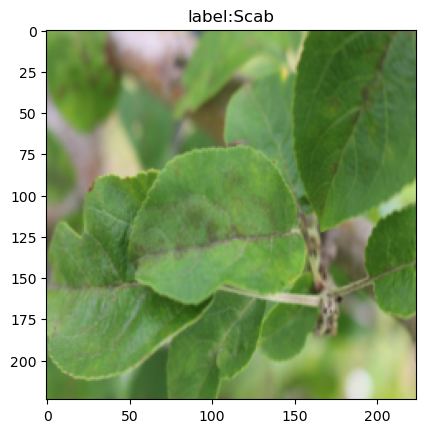

In [23]:
# 原始图像
idx = 2
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(np.clip(images[idx].transpose((1,2,0)) * std + mean, 0, 1))
plt.title('label:'+ pred_classname)
plt.show()

# 导入train所需包

In [24]:
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler

# CBAM

In [25]:
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F
import math

## 以下是CBAM代码
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F

class ChannelAttentionModule(nn.Module):
    def __init__(self, channel, ratio=16):
        super(ChannelAttentionModule, self).__init__()
        #使用自适应池化缩减map的大小，保持通道不变
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
 
        self.shared_MLP = nn.Sequential(
            nn.Conv2d(channel, channel // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channel // ratio, channel, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        avgout = self.shared_MLP(self.avg_pool(x))
        maxout = self.shared_MLP(self.max_pool(x))
        return self.sigmoid(avgout + maxout)
 
class SpatialAttentionModule(nn.Module):
    def __init__(self):
        super(SpatialAttentionModule, self).__init__()
        self.conv2d = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=7, stride=1, padding=3)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        #map尺寸不变，缩减通道
        avgout = torch.mean(x, dim=1, keepdim=True)
        maxout, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avgout, maxout], dim=1)
        out = self.sigmoid(self.conv2d(out))
        return out
 
class CBAM(nn.Module):
    def __init__(self, channel):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttentionModule(channel)
        self.spatial_attention = SpatialAttentionModule()
 
    def forward(self, x):
        out = self.channel_attention(x) * x
        out = self.spatial_attention(out) * out
        return out


class InceptionA(nn.Module):
    def __init__(self, in_channels):
        super(InceptionA,self).__init__()
        # 第二个分支
        self.branch1_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        # 第三个分支
        self.branch5_5_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch5_5_2 = nn.Conv2d(16, 24, kernel_size=5, padding=2)
        # 第四个分支
        self.branch3_3_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch3_3_2 = nn.Conv2d(16, 24, kernel_size=3, padding=1)
        self.branch3_3_3 = nn.Conv2d(24, 24, kernel_size=3, padding=1)
        # 第一个分支
        self.branch_pool = nn.Conv2d(in_channels, 24, kernel_size=1)
    def forward(self, x):

        branch1_1 = self.branch1_1(x)
        
        branch5_5 = self.branch5_5_1(x)
        branch5_5 = self.branch5_5_2(branch5_5)
        
        branch3_3 = self.branch3_3_1(x)
        branch3_3 = self.branch3_3_2(branch3_3)
        branch3_3 = self.branch3_3_3(branch3_3)
        
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)
        
        outputs = [branch1_1, branch5_5, branch3_3, branch_pool]
        return torch.cat(outputs, dim=1) # (b, c, w, h),则dim=1，即按照通道进行拼接。


In [26]:
cbam_custom_64 = CBAM(256)



# 迁移学习模型设置

In [27]:
model = models.resnet50(pretrained=True) # 载入预训练模型
# 加入CBAM
# model.layer1 = nn.Sequential(model.layer1[0],cbam_custom_64,model.layer1[1],cbam_custom_64)
model.fc = nn.Linear(model.fc.in_features, n_class)

optimizer = optim.Adam(model.parameters())

In [28]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 训练参数配置

In [29]:
model = model.to(device)

# 交叉熵损失函数
criterion = nn.CrossEntropyLoss() 

# 训练轮次 Epoch
EPOCHS = 30

# 学习率降低策略
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# 训练集上训练

In [30]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
def train_one_batch(images, labels):
    '''
    运行一个 batch 的训练，返回当前 batch 的训练日志
    '''
    
    # 获得一个 batch 的数据和标注
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = model(images) # 输入模型，执行前向预测
    loss = criterion(outputs, labels) # 计算当前 batch 中，每个样本的平均交叉熵损失函数值
    
    # 优化更新权重
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 获取当前 batch 的标签类别和预测类别
    _, preds = torch.max(outputs, 1) # 获得当前 batch 所有图像的预测类别
    preds = preds.cpu().numpy()
    loss = loss.detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    
    log_train = {}
    log_train['epoch'] = epoch
    log_train['batch'] = batch_idx
    # 计算分类评估指标
    log_train['train_loss'] = loss
    log_train['train_accuracy'] = accuracy_score(labels, preds)
    log_train['train_precision'] = precision_score(labels, preds, average='macro')
    log_train['train_recall'] = recall_score(labels, preds, average='macro')
    log_train['train_f1-score'] = f1_score(labels, preds, average='macro')
    
    return log_train

# 测试集上测试

In [31]:
def evaluate_testset():
    '''
    在整个测试集上评估，返回分类评估指标日志
    '''

    loss_list = []
    labels_list = []
    preds_list = []
    
    with torch.no_grad():
        for images, labels in test_loader: # 生成一个 batch 的数据和标注
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images) # 输入模型，执行前向预测

            # 获取整个测试集的标签类别和预测类别
            _, preds = torch.max(outputs, 1) # 获得当前 batch 所有图像的预测类别
            preds = preds.cpu().numpy()
            loss = criterion(outputs, labels) # 由 logit，计算当前 batch 中，每个样本的平均交叉熵损失函数值
            loss = loss.detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()

            loss_list.append(loss)
            labels_list.extend(labels)
            preds_list.extend(preds)
        
    log_test = {}
    log_test['epoch'] = epoch
    
    # 计算分类评估指标
    log_test['test_loss'] = np.mean(loss_list)
    log_test['test_accuracy'] = accuracy_score(labels_list, preds_list)
    log_test['test_precision'] = precision_score(labels_list, preds_list, average='macro')
    log_test['test_recall'] = recall_score(labels_list, preds_list, average='macro')
    log_test['test_f1-score'] = f1_score(labels_list, preds_list, average='macro')
    
    return log_test

# 训练集之前，记录训练日志

In [32]:
import pandas as pd
epoch = 0
batch_idx = 0
best_test_accuracy = 0

In [33]:
# 训练日志-训练集
df_train_log = pd.DataFrame()
log_train = {}
log_train['epoch'] = 0
log_train['batch'] = 0
images, labels = next(iter(train_loader))
log_train.update(train_one_batch(images, labels))
df_train_log = df_train_log.append(log_train, ignore_index=True)

In [34]:
df_train_log

epoch  batch train_loss  train_accuracy  train_precision  train_recall  \
0    0.0    0.0  2.1326554         0.21875         0.215278      0.163462   

   train_f1-score  
0        0.151786

In [35]:
# 训练日志-测试集
df_test_log = pd.DataFrame()
log_test = {}
log_test['epoch'] = 0
log_test.update(evaluate_testset())
df_test_log = df_test_log.append(log_test, ignore_index=True)

In [36]:
df_test_log

epoch  test_loss  test_accuracy  test_precision  test_recall  test_f1-score
0    0.0   1.972587       0.319945        0.247351     0.119376       0.092848

# 安装wandb


In [37]:
import wandb

wandb.init(project='appleleaf', name=time.strftime('%m%d%H%M%S'))

wandb: Currently logged in as: pet. Use `wandb login --relogin` to force relogin


# 开始训练

In [38]:
for epoch in range(1, EPOCHS+1):
    
    print(f'Epoch {epoch}/{EPOCHS}')
    
    ## 训练阶段
    model.train()
    for images, labels in tqdm(train_loader): # 获得一个 batch 的数据和标注
        batch_idx += 1
        log_train = train_one_batch(images, labels)
        df_train_log = df_train_log.append(log_train, ignore_index=True)
        wandb.log(log_train)
        
    lr_scheduler.step()

    ## 测试阶段
    model.eval()
    log_test = evaluate_testset()
    df_test_log = df_test_log.append(log_test, ignore_index=True)
    wandb.log(log_test)
    
    # 保存最新的最佳模型文件
    if log_test['test_accuracy'] > best_test_accuracy: 
        # 删除旧的最佳模型文件(如有)
        old_best_checkpoint_path = 'checkpoint/best-{:.3f}.pth'.format(best_test_accuracy)
        if os.path.exists(old_best_checkpoint_path):
            os.remove(old_best_checkpoint_path)
        # 保存新的最佳模型文件
        best_test_accuracy = log_test['test_accuracy']
        new_best_checkpoint_path = 'checkpoint/best-{:.3f}.pth'.format(log_test['test_accuracy'])
        torch.save(model, new_best_checkpoint_path)
        print('保存新的最佳模型', 'checkpoint/best-{:.3f}.pth'.format(best_test_accuracy))
        # best_test_accuracy = log_test['test_accuracy']

df_train_log.to_csv('训练日志-训练集.csv', index=False)
df_test_log.to_csv('训练日志-测试集.csv', index=False)

Epoch 1/30


100%|████████████████████████████████████████| 365/365 [01:18<00:00,  4.66it/s]


保存新的最佳模型 checkpoint/best-0.866.pth
Epoch 2/30


100%|████████████████████████████████████████| 365/365 [01:17<00:00,  4.70it/s]


Epoch 3/30


100%|████████████████████████████████████████| 365/365 [01:17<00:00,  4.68it/s]


保存新的最佳模型 checkpoint/best-0.875.pth
Epoch 4/30


100%|████████████████████████████████████████| 365/365 [01:18<00:00,  4.67it/s]


保存新的最佳模型 checkpoint/best-0.895.pth
Epoch 5/30


100%|████████████████████████████████████████| 365/365 [01:32<00:00,  3.94it/s]


保存新的最佳模型 checkpoint/best-0.923.pth
Epoch 6/30


100%|████████████████████████████████████████| 365/365 [01:44<00:00,  3.51it/s]


保存新的最佳模型 checkpoint/best-0.943.pth
Epoch 7/30


100%|████████████████████████████████████████| 365/365 [01:43<00:00,  3.51it/s]


保存新的最佳模型 checkpoint/best-0.944.pth
Epoch 8/30


100%|████████████████████████████████████████| 365/365 [01:52<00:00,  3.25it/s]


Epoch 9/30


100%|████████████████████████████████████████| 365/365 [01:54<00:00,  3.19it/s]


Epoch 10/30


100%|████████████████████████████████████████| 365/365 [01:56<00:00,  3.12it/s]


Epoch 11/30


100%|████████████████████████████████████████| 365/365 [01:48<00:00,  3.35it/s]


保存新的最佳模型 checkpoint/best-0.947.pth
Epoch 12/30


100%|████████████████████████████████████████| 365/365 [01:43<00:00,  3.51it/s]


保存新的最佳模型 checkpoint/best-0.957.pth
Epoch 13/30


100%|████████████████████████████████████████| 365/365 [01:39<00:00,  3.66it/s]


Epoch 14/30


100%|████████████████████████████████████████| 365/365 [01:49<00:00,  3.35it/s]


Epoch 15/30


100%|████████████████████████████████████████| 365/365 [01:40<00:00,  3.62it/s]


Epoch 16/30


100%|████████████████████████████████████████| 365/365 [01:48<00:00,  3.37it/s]


保存新的最佳模型 checkpoint/best-0.957.pth
Epoch 17/30


100%|████████████████████████████████████████| 365/365 [01:40<00:00,  3.63it/s]


保存新的最佳模型 checkpoint/best-0.958.pth
Epoch 18/30


100%|████████████████████████████████████████| 365/365 [01:42<00:00,  3.57it/s]


保存新的最佳模型 checkpoint/best-0.959.pth
Epoch 19/30


100%|████████████████████████████████████████| 365/365 [01:35<00:00,  3.83it/s]


Epoch 20/30


100%|████████████████████████████████████████| 365/365 [01:38<00:00,  3.69it/s]


Epoch 21/30


100%|████████████████████████████████████████| 365/365 [01:36<00:00,  3.78it/s]


Epoch 22/30


100%|████████████████████████████████████████| 365/365 [01:35<00:00,  3.82it/s]


Epoch 23/30


100%|████████████████████████████████████████| 365/365 [01:43<00:00,  3.51it/s]


Epoch 24/30


100%|████████████████████████████████████████| 365/365 [01:48<00:00,  3.35it/s]


Epoch 25/30


100%|████████████████████████████████████████| 365/365 [01:37<00:00,  3.75it/s]


Epoch 26/30


100%|████████████████████████████████████████| 365/365 [01:40<00:00,  3.64it/s]


Epoch 27/30


100%|████████████████████████████████████████| 365/365 [01:36<00:00,  3.80it/s]


Epoch 28/30


100%|████████████████████████████████████████| 365/365 [01:35<00:00,  3.84it/s]


Epoch 29/30


100%|████████████████████████████████████████| 365/365 [01:35<00:00,  3.81it/s]


Epoch 30/30


100%|████████████████████████████████████████| 365/365 [01:25<00:00,  4.29it/s]


# 可视化训练日志

In [39]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
df_train = pd.read_csv('训练日志-训练集.csv')
df_test = pd.read_csv('训练日志-测试集.csv')
# #显示所有列
# pd.set_option('display.max_columns', None)
# #显示所有行
# pd.set_option('display.max_rows', None)

In [41]:
df_train

epoch    batch  train_loss  train_accuracy  train_precision  \
0        0.0      0.0    2.132655        0.218750         0.215278   
1        1.0      1.0    1.532946        0.468750         0.200617   
2        1.0      2.0    1.057043        0.625000         0.434696   
3        1.0      3.0    1.520826        0.468750         0.266098   
4        1.0      4.0    1.354636        0.500000         0.312500   
5        1.0      5.0    0.790966        0.718750         0.587755   
6        1.0      6.0    1.376665        0.625000         0.414966   
7        1.0      7.0    0.983629        0.593750         0.447039   
8        1.0      8.0    1.730815        0.531250         0.305628   
9        1.0      9.0    1.061381        0.656250         0.485931   
10       1.0     10.0    0.880837        0.750000         0.570513   
11       1.0     11.0    0.735321        0.812500         0.493074   
12       1.0     12.0    0.973099        0.656250         0.484014   
13       1.0     13.0    1.313479        0.718750         0.685714   
14       1.0     14.0    1.541294        0.500000         0.479798   
15       1.0     15.0    0.691233        0.906250         0.891429   
16       1.0     16.0    1.070463        0.625000         0.501961   
17       1.0     17.0    1.283350        0.781250         0.576389   
18       1.0     18.0    1.521462        0.562500         0.288889   
19       1.0     19.0    0.873498        0.750000         0.533835   
20       1.0     20.0    1.084308        0.625000         0.602641   
21       1.0     21.0    0.863479        0.687500         0.434524   
22       1.0     22.0    0.833528        0.593750         0.323810   
23       1.0     23.0    0.778987        0.750000         0.323810   
24       1.0     24.0    0.712643        0.781250         0.562500   
25       1.0     25.0    1.075791        0.687500         0.581894   
26       1.0     26.0    0.433440        0.812500         0.691667   
27       1.0     27.0    1.227443        0.531250         0.359637   
28       1.0     28.0    0.734981        0.718750         0.515797   
29       1.0     29.0    1.084963        0.562500         0.300926   
30       1.0     30.0    0.547109        0.843750         0.886364   
31       1.0     31.0    0.575739        0.843750         0.581481   
32       1.0     32.0    0.471839        0.843750         0.477183   
33       1.0     33.0    0.847776        0.718750         0.622334   
34       1.0     34.0    0.793598        0.687500         0.533163   
35       1.0     35.0    0.553106        0.781250         0.527778   
36       1.0     36.0    0.736891        0.781250         0.527885   
37       1.0     37.0    0.625612        0.812500         0.617284   
38       1.0     38.0    0.718655        0.781250         0.481250   
39       1.0     39.0    0.498209        0.875000         0.735374   
40       1.0     40.0    0.535610        0.875000         0.727891   
41       1.0     41.0    0.758092        0.781250         0.530612   
42       1.0     42.0    1.178360        0.656250         0.406746   
43       1.0     43.0    0.660746        0.812500         0.634921   
44       1.0     44.0    0.873031        0.781250         0.598810   
45       1.0     45.0    0.600690        0.812500         0.564904   
46       1.0     46.0    0.643987        0.812500         0.583333   
47       1.0     47.0    1.033673        0.718750         0.583516   
48       1.0     48.0    0.646479        0.812500         0.544615   
49       1.0     49.0    0.661480        0.781250         0.556548   
50       1.0     50.0    0.925354        0.750000         0.564338   
51       1.0     51.0    0.608360        0.781250         0.590476   
52       1.0     52.0    0.689857        0.843750         0.414286   
53       1.0     53.0    0.797686        0.656250         0.725490   
54       1.0     54.0    0.627060        0.843750         0.542857   
55       1.0     55.0    0.999602        0.718750         0.579592   
56       1.0     

In [42]:
df_test

epoch  test_loss  test_accuracy  test_precision  test_recall  \
0     0.0   1.972587       0.319945        0.247351     0.119376   
1     1.0   0.465645       0.866117        0.853260     0.742245   
2     2.0   0.903600       0.726742        0.665690     0.772639   
3     3.0   0.434608       0.875043        0.836349     0.802603   
4     4.0   0.359228       0.894954        0.894779     0.838556   
5     5.0   0.261806       0.923447        0.877824     0.889384   
6     6.0   0.211836       0.943357        0.899597     0.914561   
7     7.0   0.182188       0.944387        0.918480     0.907048   
8     8.0   0.226739       0.933059        0.911741     0.903594   
9     9.0   0.207536       0.942671        0.908346     0.916257   
10   10.0   0.327165       0.923447        0.897461     0.869798   
11   11.0   0.185064       0.947477        0.938396     0.919084   
12   12.0   0.175527       0.957089        0.937634     0.933653   
13   13.0   0.187947       0.949537        0.927936     0.921627   
14   14.0   0.213478       0.953999        0.951255     0.922676   
15   15.0   0.173039       0.955029        0.932393     0.933664   
16   16.0   0.177972       0.957432        0.945861     0.933626   
17   17.0   0.169399       0.958462        0.930118     0.939559   
18   18.0   0.186875       0.958805        0.945256     0.938133   
19   19.0   0.198934       0.955372        0.934337     0.931292   
20   20.0   0.217568       0.949193        0.920667     0.933930   
21   21.0   0.198637       0.952626        0.922894     0.930168   
22   22.0   0.197136       0.957775        0.940173     0.939878   
23   23.0   0.206779       0.954343        0.940310     0.933087   
24   24.0   0.222307       0.949193        0.924985     0.931389   
25   25.0   0.195958       0.956402        0.929177     0.936421   
26   26.0   0.212796       0.953313        0.926970     0.933263   
27   27.0   0.216051       0.955716        0.935411     0.934809   
28   28.0   0.193601       0.956746        0.932502     0.939257   
29   29.0   0.216866       0.953999        0.931297     0.936233   
30   30.0   0.206769       0.952626        0.922032     0.931593   

    test_f1-score  
0        0.092848  
1        0.772116  
2        0.666799  
3        0.806428  
4        0.861790  
5        0.876630  
6        0.905404  
7        0.909150  
8        0.906946  
9        0.909757  
10       0.868000  
11       0.927514  
12       0.934806  
13       0.924139  
14       0.935402  
15       0.932682  
16       0.939302  
17       0.934531  
18       0.940361  
19       0.932313  
20       0.924089  
21       0.925961  
22       0.938160  
23       0.935412  
24       0.926726  
25       0.932375  
26       0.928276  
27       0.934024  
28       0.934789  
29       0.932025  
30       0.926048

# 训练集的准确率和损失函数

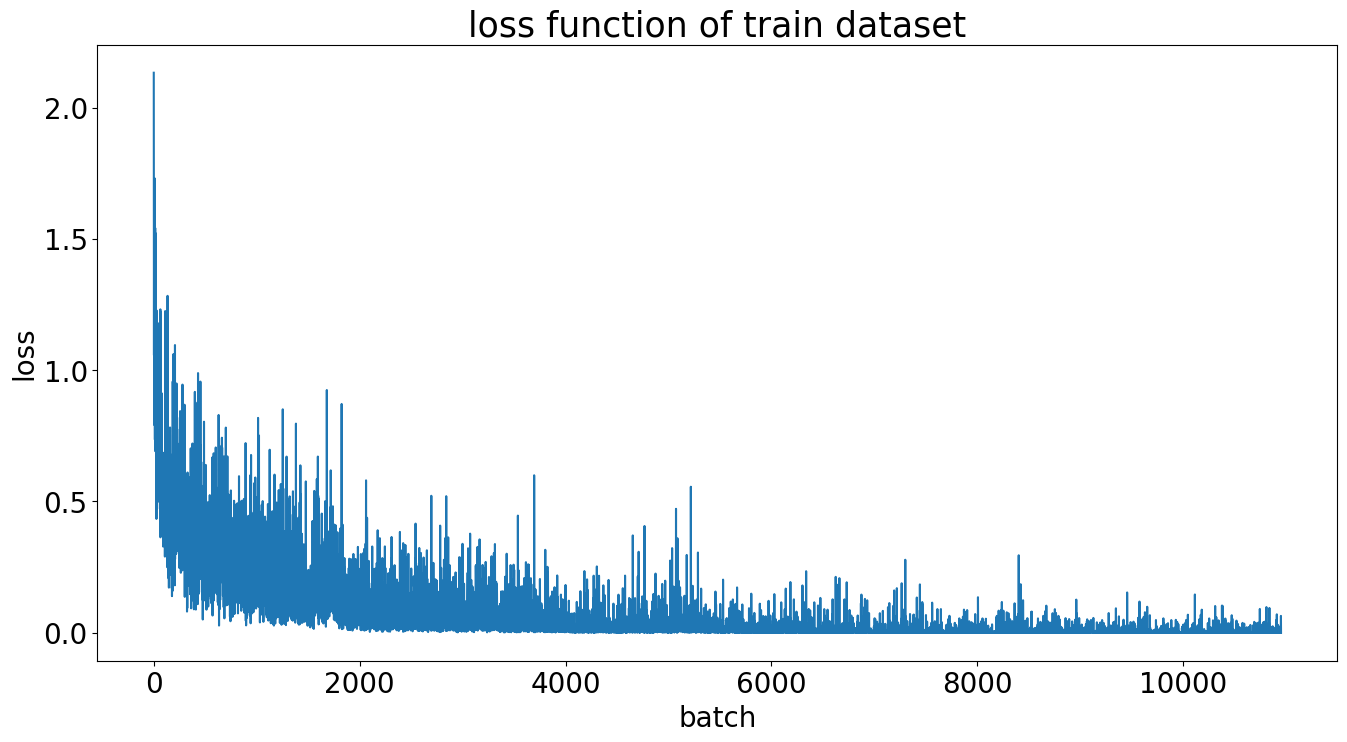

In [56]:
plt.figure(figsize=(16, 8))

x = df_train['batch']
y = df_train['train_loss']

plt.plot(x, y, label='train dataset')

plt.tick_params(labelsize=20)
plt.xlabel('batch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.title('loss function of train dataset', fontsize=25)
plt.savefig('图表1/训练集损失函数.pdf', dpi=120, bbox_inches='tight')

plt.show()

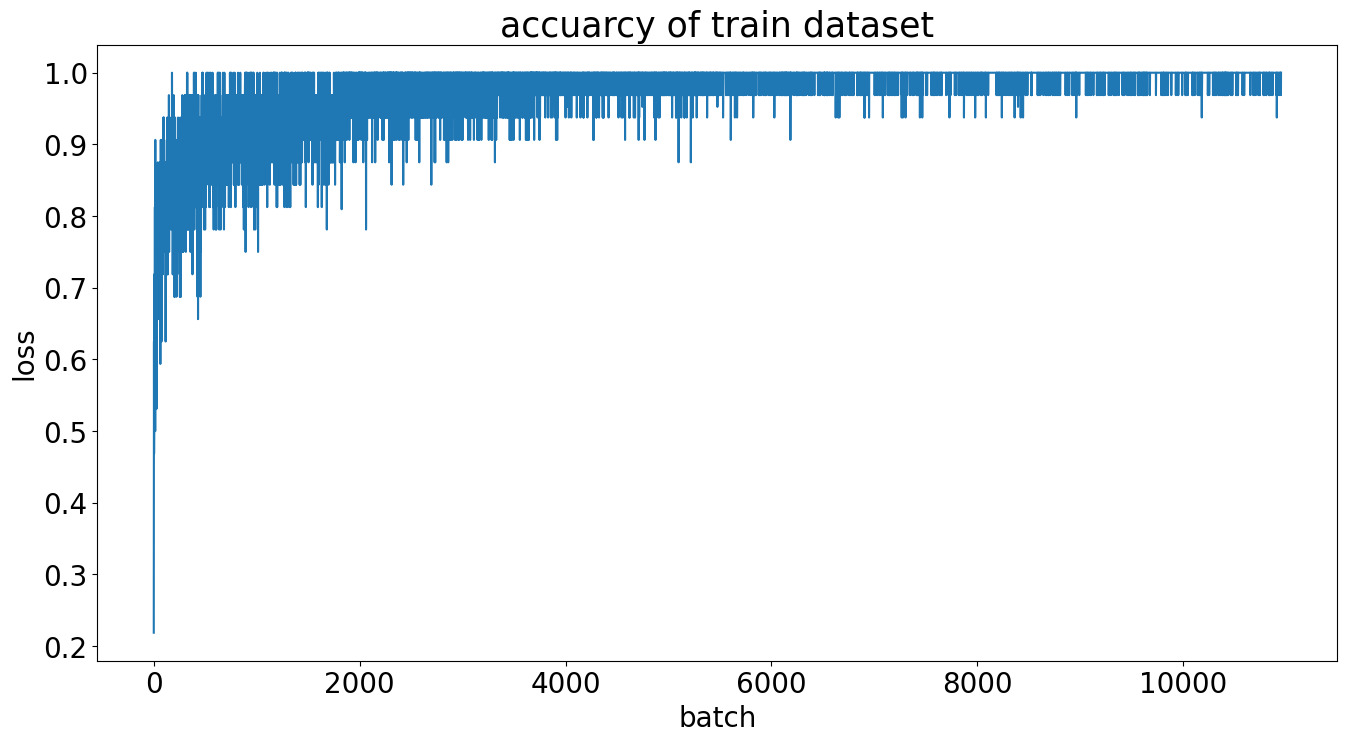

In [55]:
plt.figure(figsize=(16, 8))

x = df_train['batch']
y = df_train['train_accuracy']

plt.plot(x, y, label='训练集')

plt.tick_params(labelsize=20)
plt.xlabel('batch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.title('accuarcy of train dataset', fontsize=25)
plt.savefig('图表1/训练集准确率.pdf', dpi=120, bbox_inches='tight')

plt.show()

# 验证集损失函数

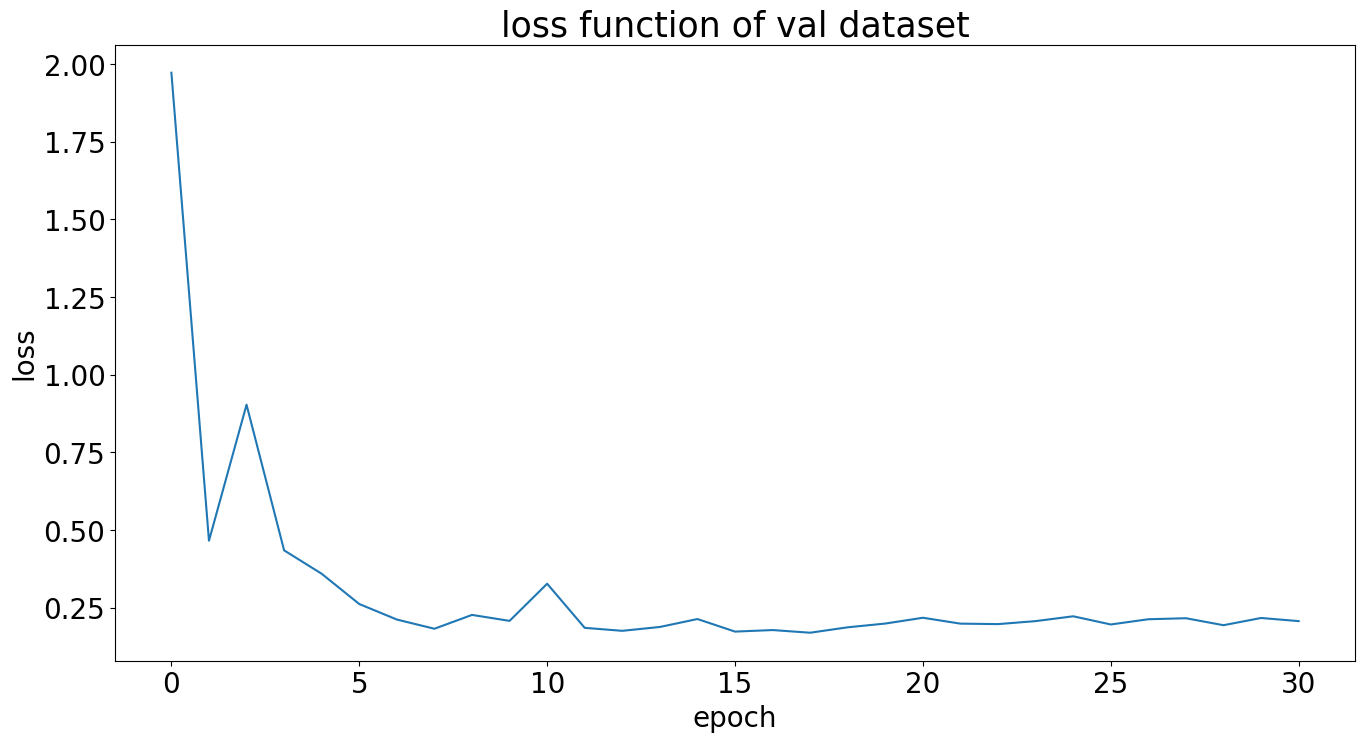

In [54]:
plt.figure(figsize=(16, 8))

x = df_test['epoch']
y = df_test['test_loss']

plt.plot(x, y, label='测试集')

plt.tick_params(labelsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.title('loss function of val dataset', fontsize=25)
plt.savefig('图表1/测试集损失函数.pdf', dpi=120, bbox_inches='tight')

plt.show()

# 验证集集评估指标

In [51]:
from matplotlib import colors as mcolors
import random
random.seed(124)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red', 'sienna', 'chocolate', 'yellow', 'olivedrab', 'yellowgreen', 'darkolivegreen', 'forestgreen', 'limegreen', 'darkgreen', 'green', 'lime', 'seagreen', 'mediumseagreen', 'darkslategray', 'darkslategrey', 'teal', 'darkcyan', 'dodgerblue', 'navy', 'darkblue', 'mediumblue', 'blue', 'slateblue', 'darkslateblue', 'mediumslateblue', 'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo', 'darkorchid', 'darkviolet', 'mediumorchid', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 'orchid', 'mediumvioletred', 'deeppink', 'hotpink']
markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
linestyle = ['--', '-.', '-']
def get_line_arg():
    '''
    随机产生一种绘图线型
    '''
    line_arg = {}
    line_arg['color'] = random.choice(colors)
    # line_arg['marker'] = random.choice(markers)
    line_arg['linestyle'] = random.choice(linestyle)
    line_arg['linewidth'] = random.randint(1, 4)
    # line_arg['markersize'] = random.randint(3, 5)
    return line_arg


In [47]:
metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1-score']

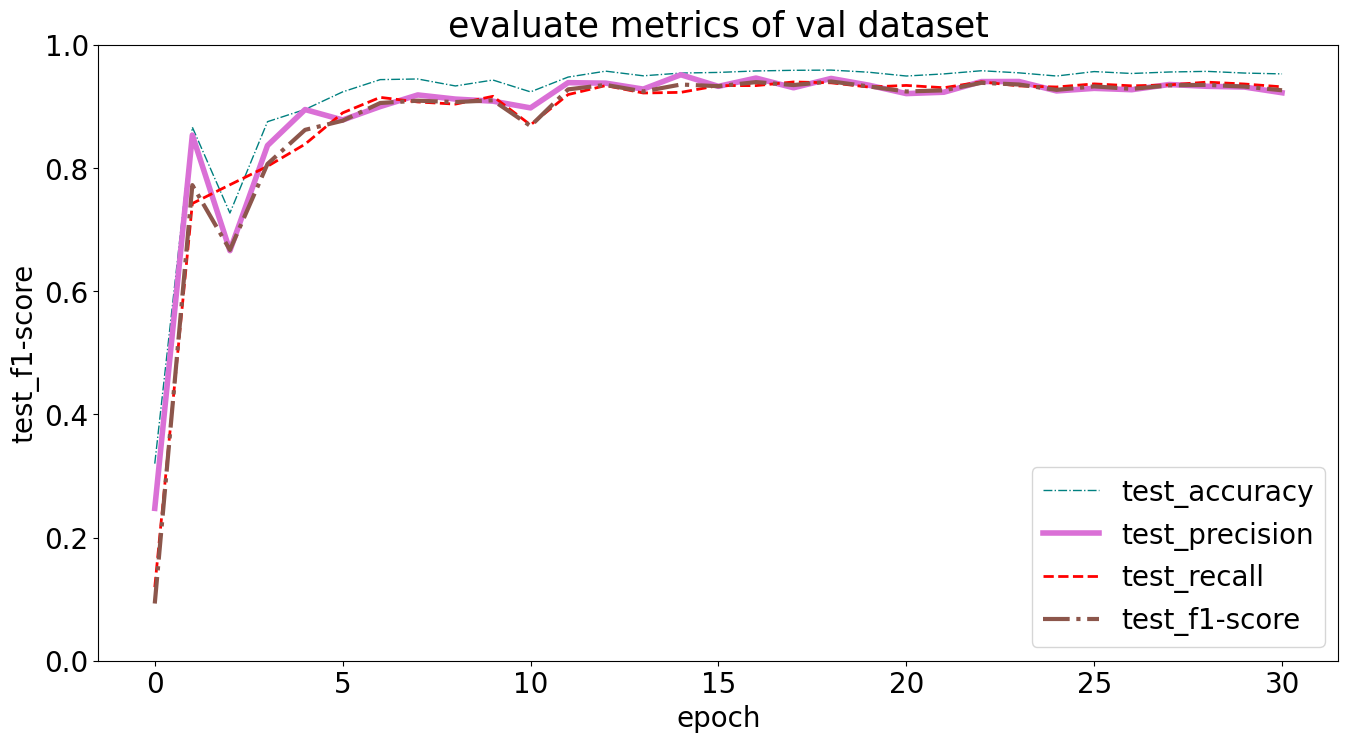

In [53]:
plt.figure(figsize=(16, 8))

x = df_test['epoch']
for y in metrics:
    plt.plot(x, df_test[y], label=y, **get_line_arg())

plt.tick_params(labelsize=20)
plt.ylim([0, 1])
plt.xlabel('epoch', fontsize=20)
plt.ylabel(y, fontsize=20)
plt.title('evaluate metrics of val dataset', fontsize=25)
plt.savefig('图表1/测试集分类评估指标.pdf', dpi=120, bbox_inches='tight')

plt.legend(fontsize=20)

plt.show()